### 1. Importing Required Modules and Packages

In [57]:
import os
import sys

sys.path.append('..')
os.environ["OMP_NUM_THREADS"] = '1'  # KMeans is not parallelized, so set to 1 thread

from src.mutation import Mutation
from src.sequence import Vector, Gene
from src.eblocks import Eblock, EblockDesign
import biotite.sequence as seq
from src.primer import DesignPrimers
from src.plot import Plot

%reload_ext autoreload
%autoreload 2

### 2. Loading and Analyzing the Gene Sequence

The desired mutations should be added to a txt file. 
Here, we create a Mutation() object and parse the specified mutations. 

In [67]:
# Create a Mutation object and parse the input mutations from the files/ directory

# mutations_file = os.path.join('tests', 'randominput', '100_A0QX55_mutations.txt')
mutations_file = os.path.join('tests', 'files', 'testmutations_3.txt')


mutation_instance = Mutation()
mutation_instance.parse_mutations(mutations_file)

# Print the mutations that were parsed
mutation_instance.print_mutations()

The selected mutations are:
	Insert    	E34-STACMWGAD
	Deletion  	T106-E113 
	Combined  	M111D, A112M
	Insert    	N218-NAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA
	Deletion  	E239-Q245 
	Deletion  	A318-V325 
	Combined  	K355I, V364H, A385M, P403S
	Insert    	A546-QCYMVD
	Combined  	L665F, H693P, I703S, H676A, R682M
	Combined  	N684G, V712V, T707I, I717D, I692C
	Mutation  	G709H     
	Combined  	I768G, W772F, Y781G
	Deletion  	A829-V838 
	Insert    	R858-GVHKNESV
	Mutation  	V872N     
	Mutation  	L917A     
	Insert    	V998-GGPYKNK
	Insert    	P1043-VDNCDSSSYPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP
	Mutation  	V1077N    
	Mutation  	S1127M    


Next, we read the gene sequence and the vector that contains our gene of interest.

In [68]:
# Create a Plasmid object and parse the input plasmid from the files/ directory

# Read sequence
sequence_file = os.path.join('example_data', 'Msmegmatis_DnaE1', 'A0QX55.fasta')
vector_file = os.path.join('example_data', 'Msmegmatis_DnaE1', 'vector.dna')

gene_instance = Gene()
gene_instance.parse_sequence(sequence_file)
vector_instance = Vector(gene=gene_instance)
vector_instance.parse_vector(vector_file)

We also define an output directory for the generated files and create a snapgene object for visualization

We create an eBlockDesign instance that can initiate the design of the eblocks. Here, we choose as optimization method cost_optimization that aims to use as little basepairs as possible. Another option would be to do amount_optimization, that aims to cluster as many mutations as possible together, to get the lowest number of different eBlocks

In [69]:
# Create an Eblocks object based on the input mutations and the gene sequence

output_dir = os.path.join('tests', 'randomoutput', 'output')

design_instance = EblockDesign(mutation_instance=mutation_instance,
                            gene_instance=gene_instance,
                            vector_instance=vector_instance,
                            output_dir=output_dir,
                            verbose=True,
                            cost_optimization=True,
                            amount_optimization=False)

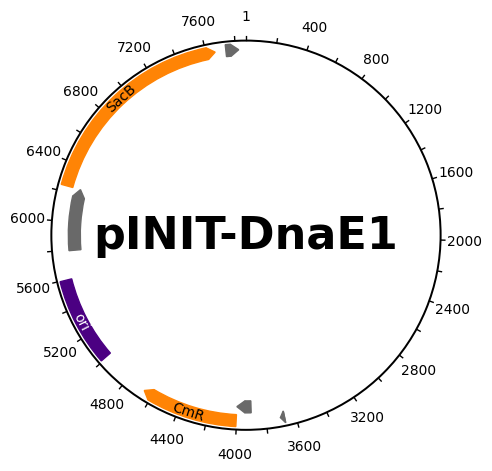

In [70]:
# Create a Plots object and check the input vector

# Create the Plot object
plot_instance = Plot(mutation_instance=mutation_instance,
                    eblocks_design_instance=design_instance,
                    vector_instance=vector_instance,
                    gene_instance=gene_instance,
                    output_dir=output_dir,
                    show=True)

# Check the input vector
plot_instance.plot_vector(figsize=(5, 5));

Calculating relative codon frequencies, based on the selected genome id U00096 ...
Starting eBlock design ...
Optimizing based on price per bp ...
Lowest estimated cost: €2241.5 (given price per bp of €0.05)
selected eblock eBlock-1 gaagatcacgcccatgctcgccgaggtggagcggctggggatgcccgcggtggggatgaccgaccacggaaacatgttcggtgccagcgagttctacaactccgcgaccaaggccgggatcaagccgatcatcggcgtggaggcatacatcgcgccgggctcgcggttcgacacccggcgcatcctgtggggtgaccccagccaaaaggccgacgacgtctccggcagcggctcctacacgcacctgacgatgatggccgagaacgccaccggtctgcgcaacctgttcaagctgtcctcgcatgcttccttcgagggccagctgagcaagtggtcgcgcatggacgccgagctcatcgccgaacacgccgagggcatcatcatcaccaccggatgcccgtcgggggaggtgcagacccgcctgcggctcggccaggatcgggaggcgctcgaagccgcggcgaagtggcgggagatcgtcggaccggacaactacttccttgagctgatggaccacgggctgaccatcgaacgccgggtccgtgacggtctgctcgagatcggacgcgcgctcaacattccgcctcttgccaccaatgactgccactacgtgacccgcgacgccgcccacaaccatgaggctttgttgtgtgtgcagaccggcaagaccctctcggatccgaatcgcttcaagttcgacggtgacggctactacctgaagtcggccgccgagatgcgccagatctgggacgacgaagtgccgggcg

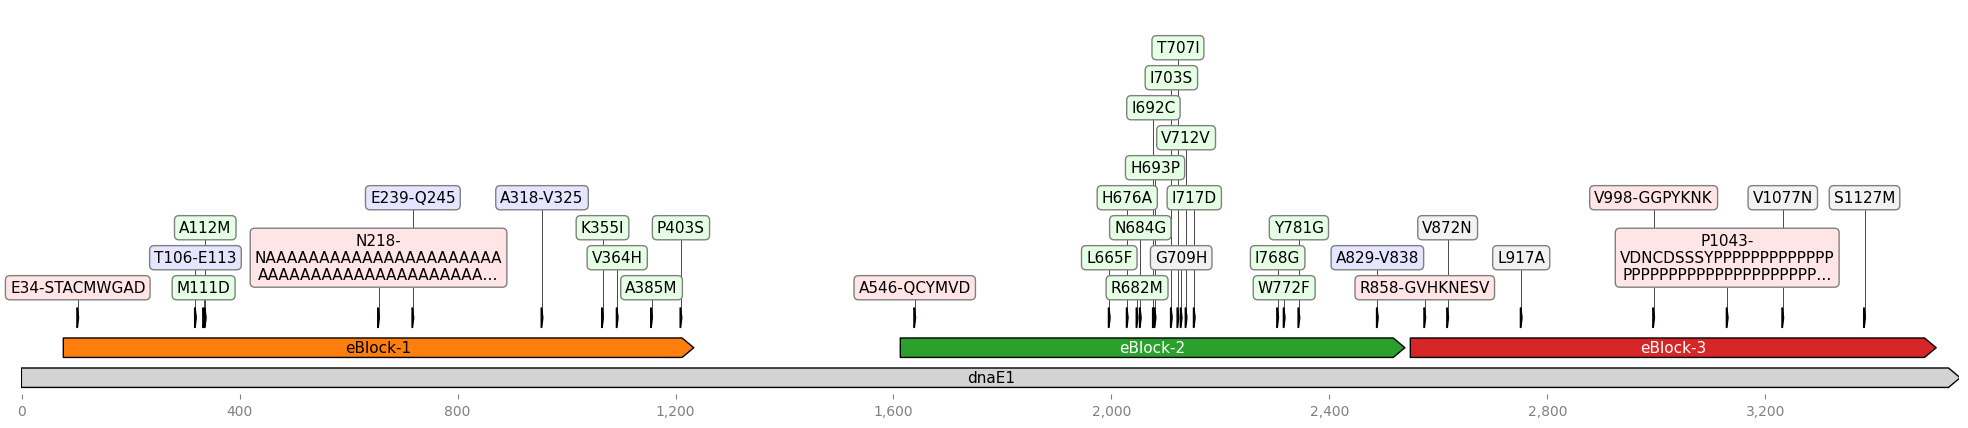

unprocessed: []


In [71]:
# Run the eBlocks design and print the results
# design_instance.max_eblock_length = 1400
design_instance.run_design_eblocks()
plot_instance.plot_eblocks_mutations(figure_length=25,
                                     figure_width=5)
print("unprocessed:", mutation_instance.unprocessed_mutations)

In [72]:
for i in design_instance.wt_eblocks:
    print(i.name, len(i.sequence))

eBlock-1 1157
eBlock-2 926
eBlock-3 965


In [73]:
for mut, eblock in design_instance.eblocks.items():
    print(eblock.name, '\t', len(eblock.sequence), '\t', mut.name)

eBlock-1 	 1184 	 E34-STACMWGAD
eBlock-1 	 1136 	 T106-E113
eBlock-1 	 1157 	 M111D-A112M
eBlock-1 	 1349 	 N218-NAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA
eBlock-1 	 1139 	 E239-Q245
eBlock-1 	 1136 	 A318-V325
eBlock-1 	 1157 	 K355I-V364H-A385M-P403S
eBlock-2 	 944 	 A546-QCYMVD
eBlock-2 	 926 	 L665F-H693P-I703S-H676A-R682M
eBlock-2 	 926 	 N684G-V712V-T707I-I717D-I692C
eBlock-2 	 926 	 G709H
eBlock-2 	 926 	 I768G-W772F-Y781G
eBlock-2 	 899 	 A829-V838
eBlock-3 	 989 	 R858-GVHKNESV
eBlock-3 	 965 	 V872N
eBlock-3 	 965 	 L917A
eBlock-3 	 986 	 V998-GGPYKNK
eBlock-3 	 1325 	 P1043-VDNCDSSSYPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP
eBlock-3 	 965 	 V1077N
eBlock-3 	 965 	 S1127M


In [49]:
for k,v in design_instance.eblocks.items():
    print(i.name, len(i.sequence), i.mutant_codon)

eBlock-3 860 None
eBlock-3 860 None
eBlock-3 860 None
eBlock-3 860 None
eBlock-3 860 None
eBlock-3 860 None
eBlock-3 860 None
eBlock-3 860 None
eBlock-3 860 None
eBlock-3 860 None
eBlock-3 860 None
eBlock-3 860 None
eBlock-3 860 None
eBlock-3 860 None
eBlock-3 860 None
eBlock-3 860 None
eBlock-3 860 None
eBlock-3 860 None
eBlock-3 860 None
eBlock-3 860 None


In [ ]:
for i in design_instance.wt_eblocks:
    print(i.name, len(i.sequence))

for i in mutation_instance.unprocessed_mutations:
    print(i.name)

In [ ]:
test1 = [1, 3, 5, 7]
test2 = [2, 4, 6, 7]
test3 = [11, 12, 7]

tests = [test1, test2, test3]

common_elements = list(set(test1).intersection(set(test2), set(test3)))
print(common_elements[0])

common_elements = list(set(test1).intersection(set([i) for i in tests))
print(common_elements[0])



In [ ]:
from collections import Counter

# Example lists (you can add more lists as needed)
lists = [
    [1, 2, 3, 4],
    [4, 5, 6, 7],
    [7, 8, 4],
    [4, 9]
]

# Create a Counter for all elements across all lists
counter = Counter()

for lst in lists:
    counter.update(set(lst))  # Use set to avoid counting duplicates in the same list

# Find elements that appear in all lists
common_elements = [item for item, count in counter.items() if count == len(lists)]

if common_elements:
    print(f"Common elements: {common_elements}")
else:
    print("No common elements found.")

In the process, for each mutation a different eBlock is created and a .gb file is made to easily view the clone in a sequence editor. 

In [ ]:
for eblock in design_instance.wt_eblocks:
    print(eblock.name, len(eblock.sequence))

print(mutation_instance.unprocessed_mutations[0].name)

In [ ]:
sequence_file = 'files/A0QX55.fasta'
vector_file = 'files/vector.dna'

sequence_instance = Plasmid()
sequence_instance.parse_vector(vector_file)
sequence_instance.parse_sequence(sequence_file)

sequence_instance.description

In [23]:
from Bio import SeqIO

def read_single_fasta(fp: str) -> str:
    """
    This function reads a single fasta file and returns the sequence.
    """
    for num, record in enumerate(SeqIO.parse(fp, "fasta")):
        sequence = record.seq
        seqid = record.id
        if num > 0:
            raise ValueError("Please provide a single sequence in FASTA format.")
    return sequence, seqid

def read_single_fasta(fp: str) -> str:
    """
    This function reads a single fasta file and returns the sequence.
    """
    record = next(SeqIO.parse(fp, "fasta"))  # Read the first and only record
    sequence = record.seq
    seqid = record.id
    return sequence, seqid

In [ ]:
seq, seqid = read_single_fasta(sequence_file)
print(seq, seqid)
seq, seqid = read_single_fasta2(sequence_file)
print(seq, seqid)